In [1863]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import KFold
from xgboostlss.distributions import *
from xgboostlss.distributions.distribution_utils import DistributionClass
import warnings
warnings.filterwarnings('ignore')

In [1864]:
X_train = pd.read_csv("X_trn.csv")
y_train = pd.read_csv("y_trn.csv")
X_test = pd.read_csv("X_test.csv")

In [1865]:
X_train.describe()
# From 1974 to 2018

,year,age,prestg10,childs
count,31607.000000,31607.000000,31607.000000,31607.000000
mean,1996.149081,41.004303,43.811149,1.692125
std,12.496894,13.498038,13.093615,1.612093
min,1974.000000,18.000000,16.000000,0.000000
25%,1986.000000,30.000000,35.000000,0.000000
50%,1996.000000,39.000000,44.000000,2.000000
75%,2006.000000,51.000000,51.000000,3.000000
max,2018.000000,89.000000,80.000000,8.000000


In [1866]:
X = X_train.copy()
X['y'] = y_train

In [1867]:
for col in X_train.select_dtypes(include=["object"]).columns:
    print(f"{col}: {X_train[col].nunique()} unique values:")
    print(f"{X_train[col].unique()}\n")

occrecode: 11 unique values:
['Office and Administrative Support' 'Business/Finance' 'Service'
 'Production' 'Professional' 'Construction/Extraction' 'Sales'
 'Installation, Maintenance, and Repair' 'Transportation' 'Armed Forces'
 'Farming, Fishing, and Forestry']

wrkstat: 8 unique values:
['Full-Time' 'Part-Time' 'Temporarily Not Working' 'Housekeeper'
 'Unemployed, Laid Off' 'School' 'Retired' 'Other']

gender: 2 unique values:
['Female' 'Male']

educcat: 5 unique values:
['Bachelor' 'Graduate' 'Junior College' 'High School'
 'Less Than High School']

maritalcat: 5 unique values:
['Widowed' 'Married' 'Never Married' 'Separated' 'Divorced']



In [1868]:
X_train["year"].unique()

array([2002, 2004, 1994, 1980, 2006, 2014, 1993, 2016, 1976, 2000, 1989,
       2012, 1978, 2018, 1975, 1986, 1998, 2008, 1991, 1974, 1996, 1988,
       1977, 1983, 2010, 1985, 1982, 1984, 1987, 1990], dtype=int64)

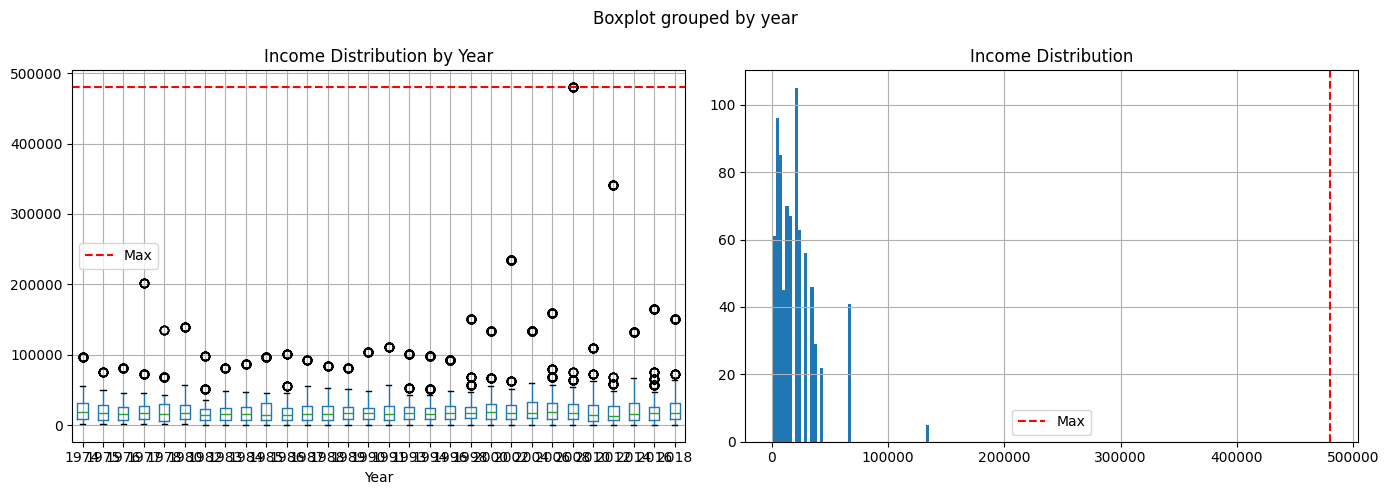

In [1869]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

X.boxplot(column='y', by='year', ax=axes[0])
axes[0].axhline(y=480144.47, color='r', linestyle='--', label='Max')
axes[0].set_title('Income Distribution by Year')
axes[0].set_xlabel('Year')
axes[0].legend()

X[X['year'] == 1978]['y'].hist(bins=50, ax=axes[1])
axes[1].axvline(x=480144.47, color='r', linestyle='--', label='Max')
axes[1].set_title('Income Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

In [1870]:
print(f"Number of unique values in y: {y_train.nunique().values[0]}")

Number of unique values in y: 602


In [1871]:
X['max_income_year'] = X.groupby('year')['y'].transform('max')
X['is_max_income'] = (X['y'] == X['max_income_year']).astype(int)

max_observations = X[X['is_max_income'] == 1].copy()

print(f"Number of observations at the max: {len(max_observations)}")
print(f"\nNumber of observations at the max by year:")
count_per_year = max_observations.groupby('year').size().sort_values(ascending=False)
print(count_per_year)

Number of observations at the max: 986

Number of observations at the max by year:
year
2004    80
1996    79
2002    59
2014    51
1994    51
2006    45
1985    45
2018    41
1993    41
2016    41
2000    41
1976    35
1984    30
1998    30
1974    27
1990    27
1989    27
2008    26
2012    26
1983    25
1988    22
1987    22
1986    21
1980    19
2010    19
1991    17
1982    14
1975    12
1977     8
1978     5
dtype: int64


In [ ]:
# Histogram of max incomes
# plt.hist(X[X["is_max_income"]==0]["y"], bins=30, color='red', alpha=0.3)
# plt.hist(X[X["is_max_income"]==1]["y"], bins=986, color='blue', alpha=0.8)

In [1873]:
topcode = X[X["is_max_income"]==1]

In [1874]:
X = X[X["is_max_income"]==0].drop(columns=['max_income_year', 'is_max_income'])
X.reset_index(drop=True, inplace=True)

y_train = X["y"]
X_train = X.drop(columns=['y'])

In [1875]:
np.argmax(X["y"])

1674

In [1876]:
X.loc[1674]

year                      2006
age                       42.0
occrecode     Business/Finance
prestg10                  53.0
childs                     4.0
wrkstat              Full-Time
gender                    Male
educcat               Graduate
maritalcat             Married
y                      79590.0
Name: 1674, dtype: object

In [1877]:
y_train.describe(percentiles=[.05, .10, .25, .50, .75, .90, .95, .99]).T

count    30621.000000
mean     18527.423464
std      13863.980509
min        227.000000
5%        1450.000000
10%       3042.000000
25%       7816.875000
50%      15793.000000
75%      25740.000000
90%      37603.000000
95%      45866.000000
99%      62570.000000
max      79590.000000
Name: y, dtype: float64

In [1878]:
print(f"Skewness: {y_train.skew()}\nKurtosis: {y_train.kurtosis()}")

Skewness: 1.0748397227053064
Kurtosis: 1.1810472012470847


Text(0, 0.5, 'Frequency')

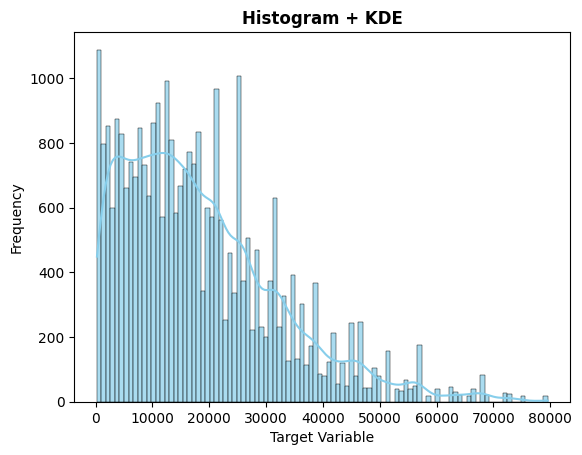

In [1879]:
sns.histplot(y_train, bins=100, kde=True, alpha=0.7, color='skyblue')
plt.title('Histogram + KDE', fontsize=12, fontweight='bold')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')

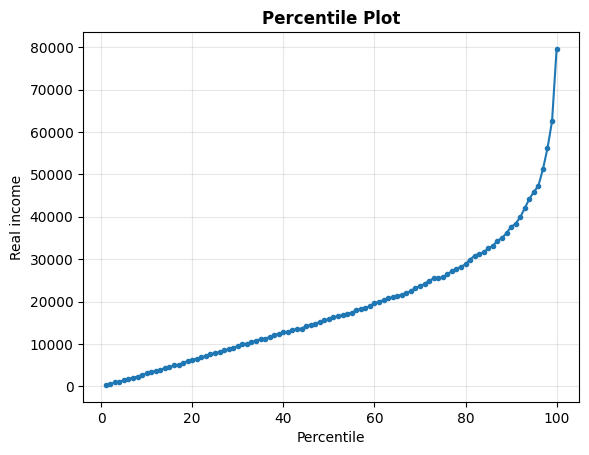

In [1880]:
percentiles = np.arange(1, 101)
values = np.percentile(y_train, percentiles)
plt.plot(percentiles, values, marker='o', markersize=3)
plt.title('Percentile Plot', fontsize=12, fontweight='bold')
plt.xlabel('Percentile')
plt.ylabel('Real income')
plt.grid(True, alpha=0.3)


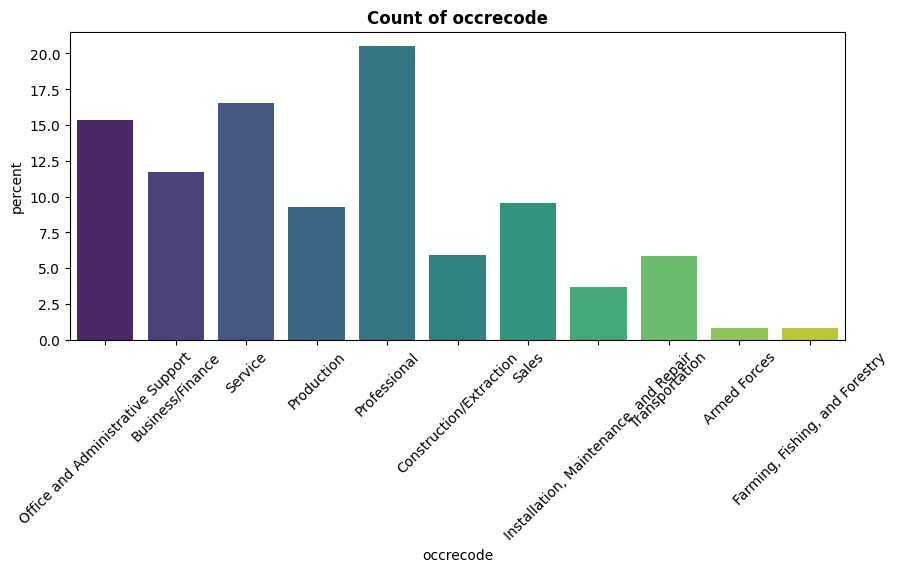

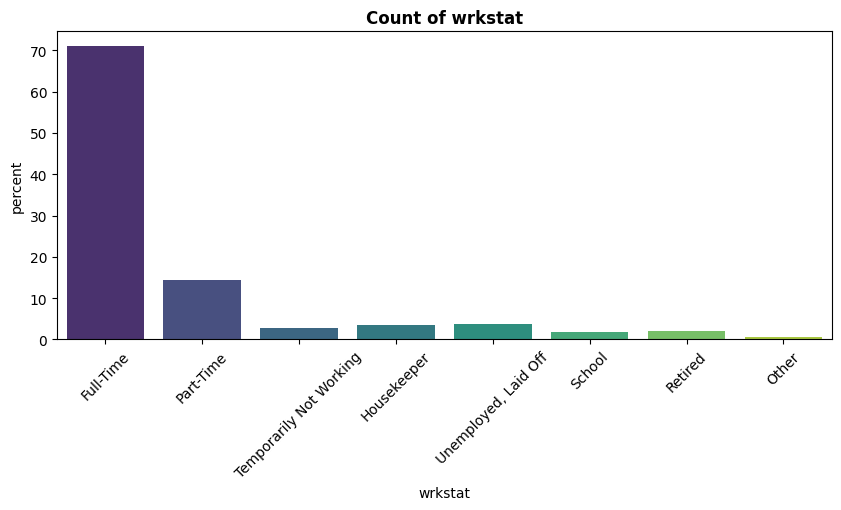

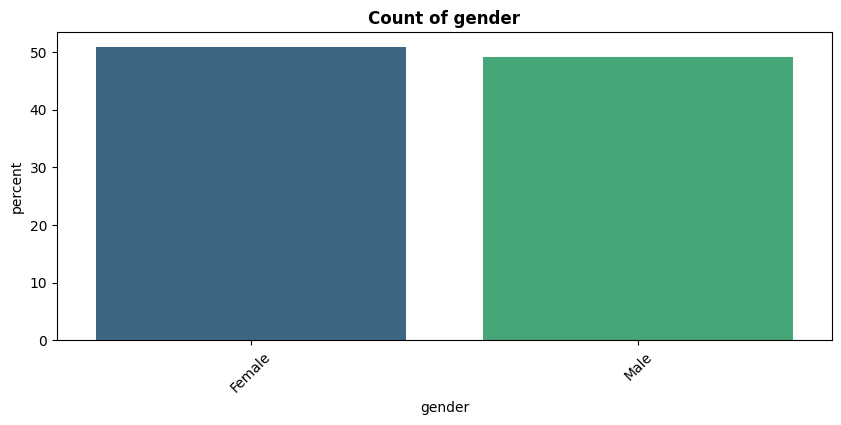

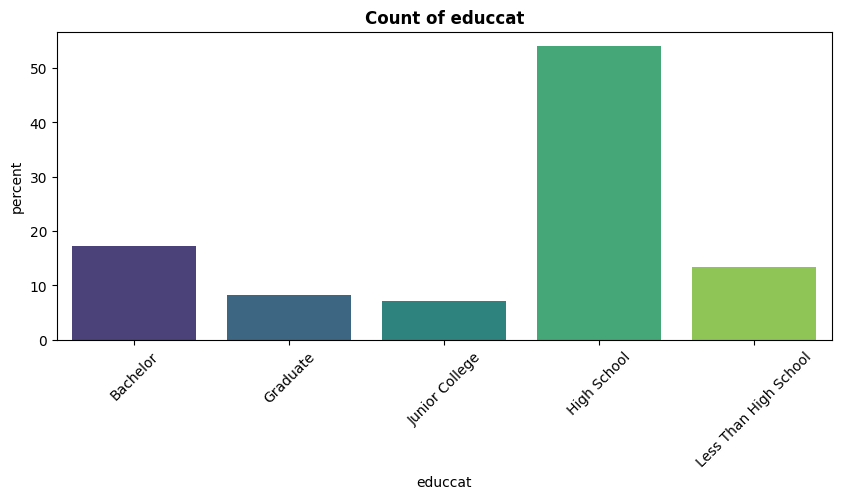

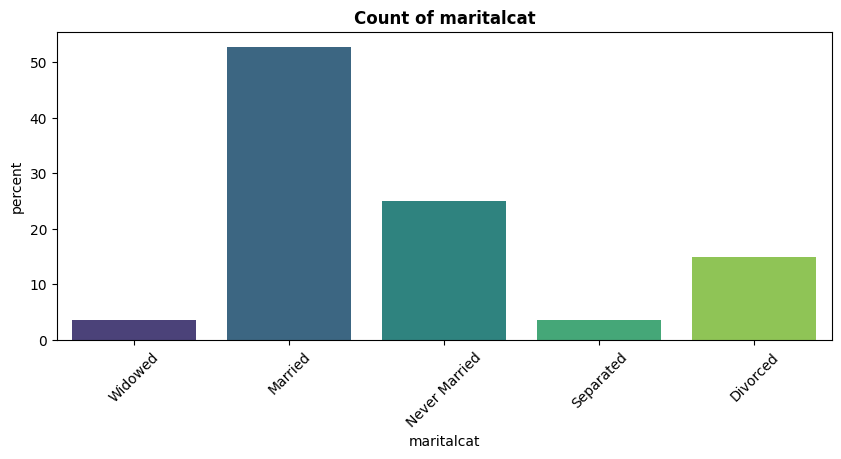

In [1881]:
for col in X_train.select_dtypes(include=["object"]).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=X_train, palette='viridis', stat="percent")
    plt.title(f'Count of {col}', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.show()


=== YEARLY TARGET STATISTICS ===
    year       mean    median        std  count       q25      q75
0   1974  19341.858  16038.00  14031.898    625  8636.000  30841.0
1   1975  17209.807  16676.00  12198.242    662  7782.000  27793.0
2   1976  17444.715  15279.00  11894.019    634  7130.000  25465.0
3   1977  19631.727  17335.00  15317.210    708  8667.000  26484.0
4   1978  19315.471  16284.00  15987.651    786  6333.000  24879.0
5   1980  19336.516  16994.00  14825.691    699  8308.000  28323.0
6   1982  16098.081  13563.00  11718.609    921  6631.000  22605.0
7   1983  16752.282  12779.00  12178.034    804  7384.000  24139.0
8   1984  16670.076  15132.00  12168.711    750  7153.000  23386.0
9   1985  17147.324  14515.00  12274.364    747  6861.000  24543.0
10  1986  17151.722  14015.00  12650.717    738  6625.000  24207.0
11  1987  17607.635  13750.00  12807.086    943  7500.000  27500.0
12  1988  17640.085  15682.00  12752.089    778  7238.000  26538.0
13  1989  17947.203  16234.50

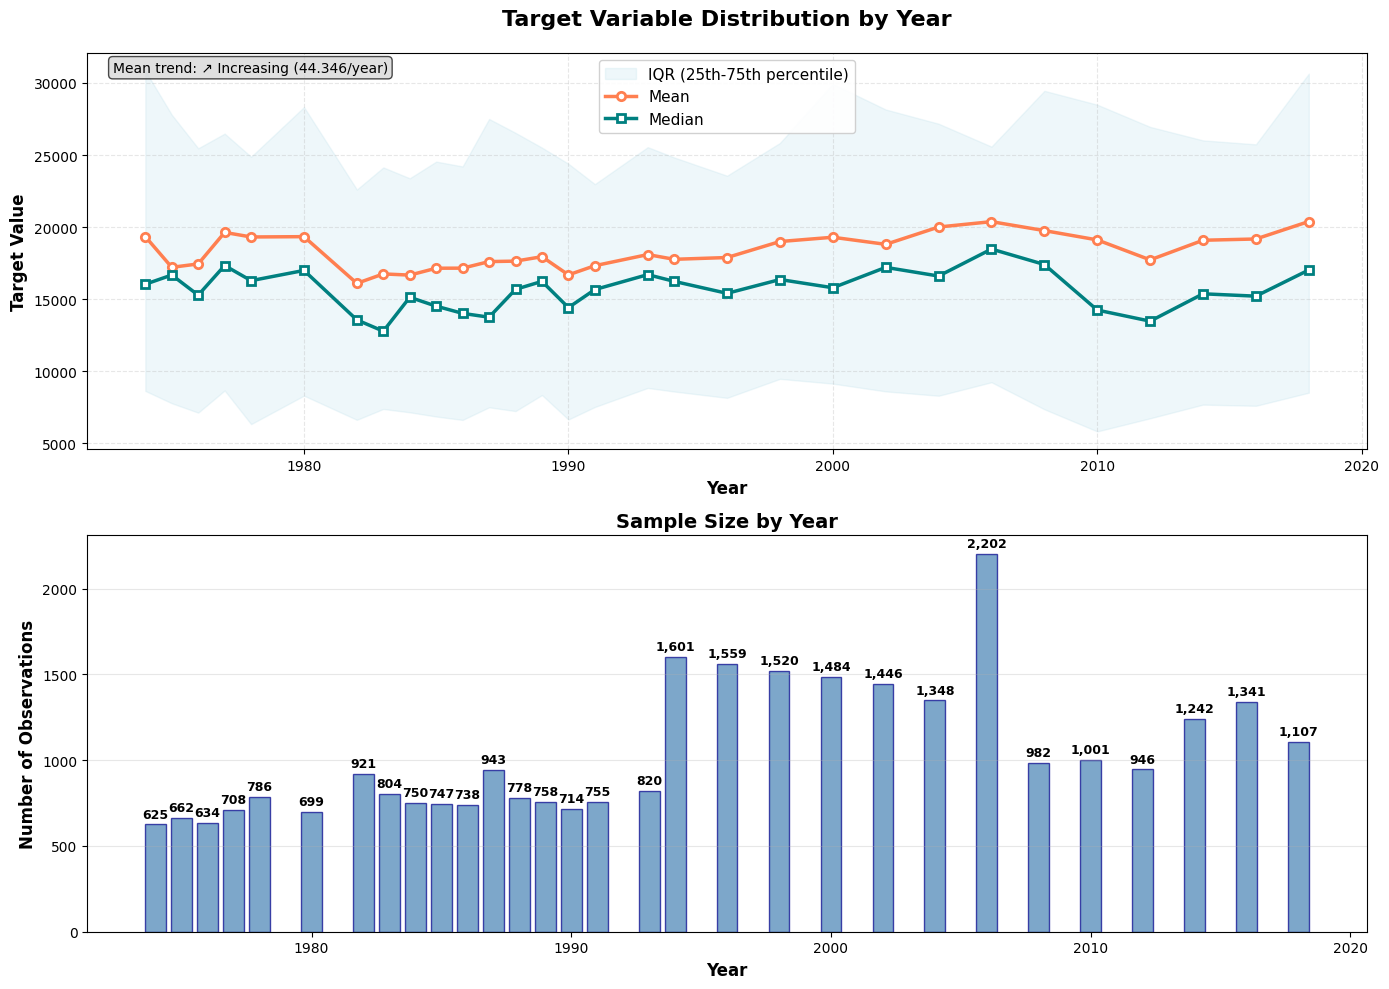

In [1882]:
yearly_stats = X.groupby('year')['y'].agg([
    'mean', 'median', 'std', 'count', 
    lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)
]).reset_index()
yearly_stats.columns = ['year', 'mean', 'median', 'std', 'count', 'q25', 'q75']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.fill_between(yearly_stats['year'], 
                yearly_stats['q25'], yearly_stats['q75'],
                alpha=0.2, color='lightblue', label='IQR (25th-75th percentile)')

line1 = ax1.plot(yearly_stats['year'], yearly_stats['mean'], 
                marker='o', linewidth=2.5, markersize=6, 
                color='coral', label='Mean', markerfacecolor='white', 
                markeredgewidth=2, markeredgecolor='coral')

line2 = ax1.plot(yearly_stats['year'], yearly_stats['median'], 
                marker='s', linewidth=2.5, markersize=6, 
                color='teal', label='Median', markerfacecolor='white',
                markeredgewidth=2, markeredgecolor='teal')

ax1.set_title('Target Variable Distribution by Year', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Target Value', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, framealpha=0.9)

if len(yearly_stats) > 1:
    mean_trend = np.polyfit(yearly_stats['year'], yearly_stats['mean'], 1)[0]
    trend_text = f"Mean trend: {'↗️ Increasing' if mean_trend > 0 else '↘️ Decreasing'} ({mean_trend:.3f}/year)"
    ax1.text(0.02, 0.98, trend_text, transform=ax1.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7),
            verticalalignment='top', fontsize=10)

bars = ax2.bar(yearly_stats['year'], yearly_stats['count'], 
               alpha=0.7, color='steelblue', edgecolor='darkblue', linewidth=1)
ax2.set_title('Sample Size by Year', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Observations', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, yearly_stats['count']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(yearly_stats['count'])*0.01,
            f'{int(count):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()

print("=== YEARLY TARGET STATISTICS ===")
print(yearly_stats.round(3))

print(f"\n=== KEY INSIGHTS ===")
print(f"Year range: {yearly_stats['year'].min()} - {yearly_stats['year'].max()}")
print(f"Total observations: {yearly_stats['count'].sum():,}")
print(f"Mean across all years: {yearly_stats['mean'].mean():.3f}")
print(f"Coefficient of variation (mean): {yearly_stats['mean'].std() / yearly_stats['mean'].mean():.3f}")

if len(yearly_stats) > 1:
    yearly_stats['mean_change'] = yearly_stats['mean'].pct_change() * 100
    yearly_stats['median_change'] = yearly_stats['median'].pct_change() * 100
    
    print(f"Largest year-over-year increase (mean): {yearly_stats['mean_change'].max():.2f}%")
    print(f"Largest year-over-year decrease (mean): {yearly_stats['mean_change'].min():.2f}%")

plt.show()

<Axes: >

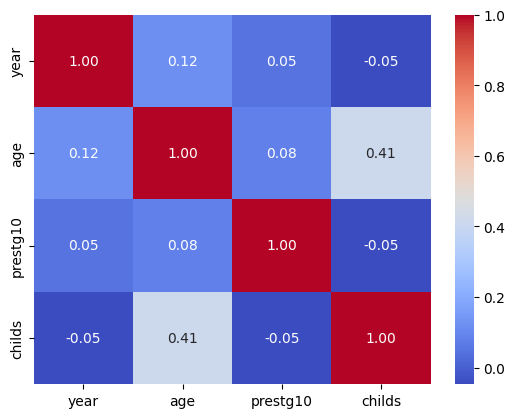

In [1883]:
sns.heatmap(X_train.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

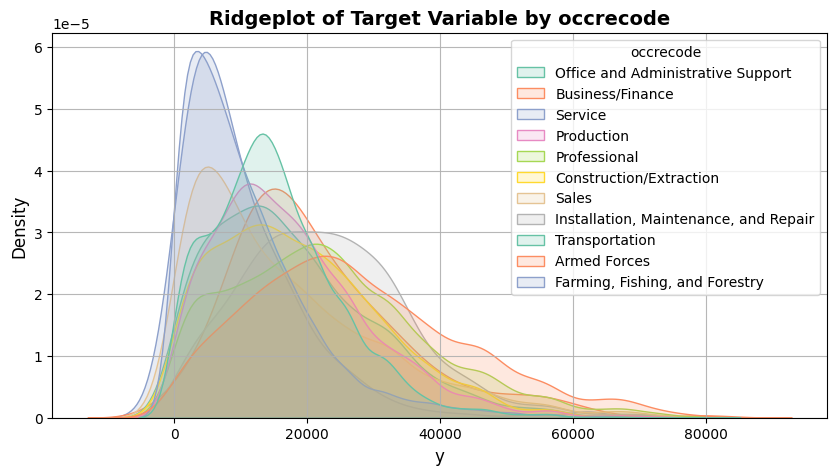

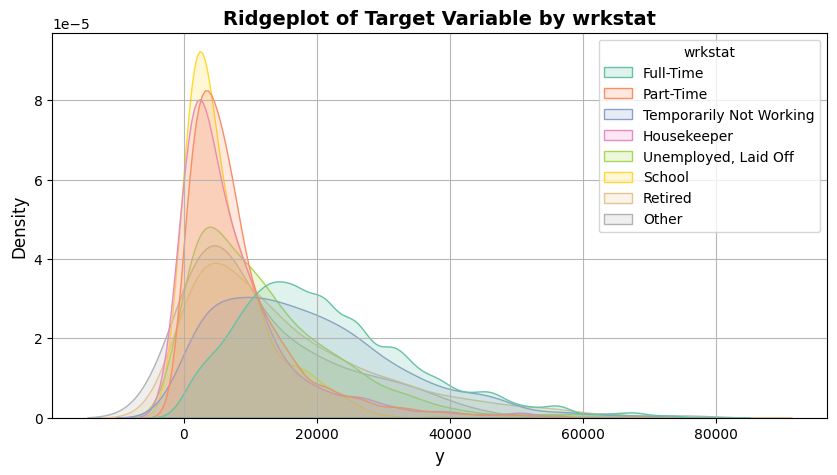

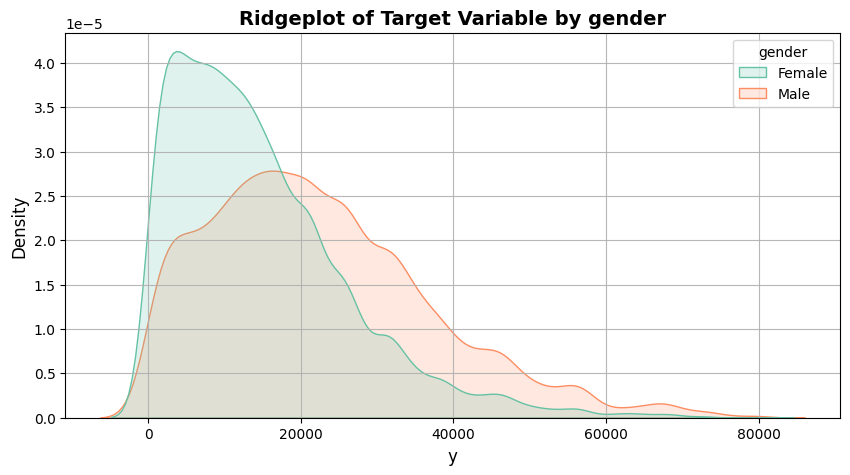

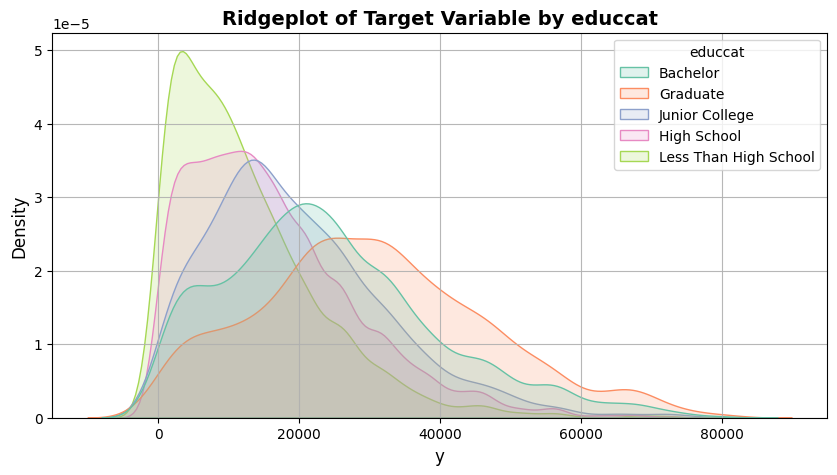

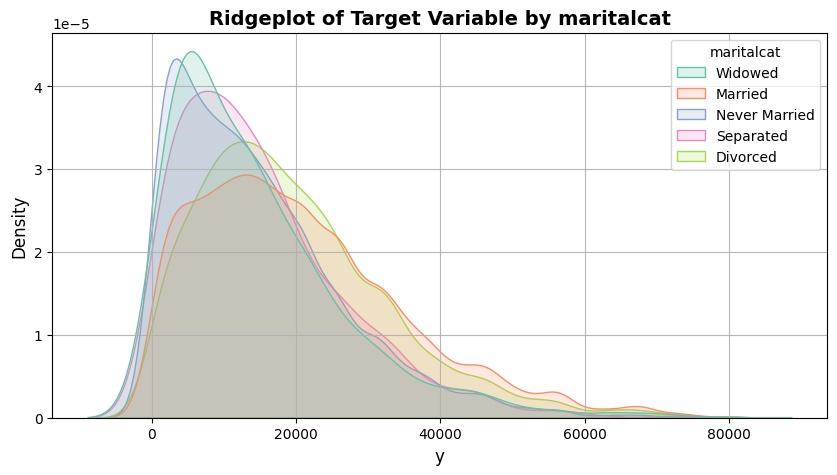

In [1884]:
for col in X_train.select_dtypes(include=["object"]).columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=X, x='y', hue=col, fill=True, common_norm=False, alpha=0.2, palette='Set2')
    plt.title(f'Ridgeplot of Target Variable by {col}', fontsize=14, fontweight='bold')
    plt.xlabel('y', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True, alpha=0.9)
    plt.show()

In [1885]:
X_train['age_bin'] = pd.cut(X_train['age'], bins=[17, 30, 50, 100], labels=['18-30', '31-50', '51+'])
X_test['age_bin'] = pd.cut(X_test['age'], bins=[17, 30, 50, 100], labels=['18-30', '31-50', '51+'])

X_train['childs_bin'] = pd.cut(X_train['childs'], bins=[-1, 2, 5, 20], labels=['0-2', '3-5', '6+'])
X_test['childs_bin'] = pd.cut(X_test['childs'], bins=[-1, 2, 5, 20], labels=['0-2', '3-5', '6+'])

X_train['prestg10_bin'] = pd.cut(X_train['prestg10'], bins=[0, 30, 50, 100], labels=['16-30', '31-50', '51+'])
X_test['prestg10_bin'] = pd.cut(X_test['prestg10'], bins=[0, 30, 50, 100], labels=['16-30', '31-50', '51+'])


for col in X_train.select_dtypes(include=["category"]).columns:
    X_train[col] = X_train[col].astype("object")

for col in X_test.select_dtypes(include=["category"]).columns:
    X_test[col] = X_test[col].astype("object")

In [ ]:
from scipy.stats import chi2_contingency
cat_cols = X_train.select_dtypes(include=["object"]).columns

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))    
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        table = pd.crosstab(X_train[cat_cols[i]], X_train[cat_cols[j]])
        v = cramers_v(table)
        print(f"{cat_cols[i]} vs {cat_cols[j]} : Cramér's V = {v:.3f}")


occrecode vs wrkstat : Cramér's V = 0.095
occrecode vs gender : Cramér's V = 0.433
occrecode vs educcat : Cramér's V = 0.302
occrecode vs maritalcat : Cramér's V = 0.069
occrecode vs age_bin : Cramér's V = 0.087
occrecode vs childs_bin : Cramér's V = 0.070
occrecode vs prestg10_bin : Cramér's V = 0.565
wrkstat vs gender : Cramér's V = 0.223
wrkstat vs educcat : Cramér's V = 0.070
wrkstat vs maritalcat : Cramér's V = 0.115
wrkstat vs age_bin : Cramér's V = 0.222
wrkstat vs childs_bin : Cramér's V = 0.069
wrkstat vs prestg10_bin : Cramér's V = 0.108
gender vs educcat : Cramér's V = 0.071
gender vs maritalcat : Cramér's V = 0.143
gender vs age_bin : Cramér's V = 0.008
gender vs childs_bin : Cramér's V = 0.016
gender vs prestg10_bin : Cramér's V = 0.036
educcat vs maritalcat : Cramér's V = 0.062
educcat vs age_bin : Cramér's V = 0.121
educcat vs childs_bin : Cramér's V = 0.140
educcat vs prestg10_bin : Cramér's V = 0.384
maritalcat vs age_bin : Cramér's V = 0.346
maritalcat vs childs_bin :

In [1887]:
X_train["occrecode_gender"] = X_train["occrecode"].astype(str) + "_" + X_train["gender"].astype(str)
X_train["occrecode_educcat"] = X_train["occrecode"].astype(str) + "_" + X_train["educcat"].astype(str)
X_train["wrkstat_gender"] = X_train["wrkstat"].astype(str) + "_" + X_train["gender"].astype(str)
X_train["occrecode_prestg10_bin"] = X_train["occrecode"].astype(str) + "_" + X_train["prestg10_bin"].astype(str)
X_train["educcat_prestg10_bin"] = X_train["educcat"].astype(str) + "_" + X_train["prestg10_bin"].astype(str)
X_train["maritalcat_age_bin"] = X_train["maritalcat"].astype(str) + "_" + X_train["age_bin"].astype(str)

X_test["occrecode_gender"] = X_test["occrecode"].astype(str) + "_" + X_test["gender"].astype(str)
X_test["occrecode_educcat"] = X_test["occrecode"].astype(str) + "_" + X_test["educcat"].astype(str)
X_test["wrkstat_gender"] = X_test["wrkstat"].astype(str) + "_" + X_test["gender"].astype(str)
X_test["occrecode_prestg10_bin"] = X_test["occrecode"].astype(str) + "_" + X_test["prestg10_bin"].astype(str)
X_test["educcat_prestg10_bin"] = X_test["educcat"].astype(str) + "_" + X_test["prestg10_bin"].astype(str)
X_test["maritalcat_age_bin"] = X_test["maritalcat"].astype(str) + "_" + X_test["age_bin"].astype(str)

In [1888]:
def fe_log(X, cols):
    for col in cols:
        X[f"{col}_log"] = np.log1p(X[col])
    return X

X_train = fe_log(X_train, X_train.select_dtypes(include=["number"]).columns)
X_test = fe_log(X_test, X_test.select_dtypes(include=["number"]).columns)
X_train.head()

,year,age,occrecode,prestg10,childs,wrkstat,gender,educcat,maritalcat,age_bin,...,occrecode_gender,occrecode_educcat,wrkstat_gender,occrecode_prestg10_bin,educcat_prestg10_bin,maritalcat_age_bin,year_log,age_log,prestg10_log,childs_log
0,2002,31.0,Office and Administrative Support,38.0,0.0,Full-Time,Female,Bachelor,Widowed,31-50,...,Office and Administrative Support_Female,Office and Administrative Support_Bachelor,Full-Time_Female,Office and Administrative Support_31-50,Bachelor_31-50,Widowed_31-50,7.602401,3.465736,3.663562,0.000000
1,2004,51.0,Business/Finance,52.0,2.0,Full-Time,Female,Graduate,Married,51+,...,Business/Finance_Female,Business/Finance_Graduate,Full-Time_Female,Business/Finance_51+,Graduate_51+,Married_51+,7.603399,3.951244,3.970292,1.098612
2,1994,30.0,Service,48.0,2.0,Full-Time,Female,Junior College,Never Married,18-30,...,Service_Female,Service_Junior College,Full-Time_Female,Service_31-50,Junior College_31-50,Never Married_18-30,7.598399,3.433987,3.891820,1.098612
3,1980,45.0,Production,35.0,0.0,Full-Time,Female,High School,Separated,31-50,...,Production_Female,Production_High School,Full-Time_Female,Production_31-50,High School_31-50,Separated_31-50,7.591357,3.828641,3.583519,0.000000
4,2006,27.0,Professional,46.0,1.0,Full-Time,Female,Bachelor,Married,18-30,...,Professional_Female,Professional_Bachelor,Full-Time_Female,Professional_31-50,Bachelor_31-50,Married_18-30,7.604396,3.332205,3.850148,0.693147


In [1889]:
for col in X_train.select_dtypes(include=["object"]).columns:
    X_train[col] = X_train[col].str.replace(" ", "_")
    X_test[col] = X_test[col].str.replace(" ", "_")

In [1890]:
X = X_train.copy()
X['y'] = y_train
X.head()

,year,age,occrecode,prestg10,childs,wrkstat,gender,educcat,maritalcat,age_bin,...,occrecode_educcat,wrkstat_gender,occrecode_prestg10_bin,educcat_prestg10_bin,maritalcat_age_bin,year_log,age_log,prestg10_log,childs_log,y
0,2002,31.0,Office_and_Administrative_Support,38.0,0.0,Full-Time,Female,Bachelor,Widowed,31-50,...,Office_and_Administrative_Support_Bachelor,Full-Time_Female,Office_and_Administrative_Support_31-50,Bachelor_31-50,Widowed_31-50,7.602401,3.465736,3.663562,0.000000,23463.75
1,2004,51.0,Business/Finance,52.0,2.0,Full-Time,Female,Graduate,Married,51+,...,Business/Finance_Graduate,Full-Time_Female,Business/Finance_51+,Graduate_51+,Married_51+,7.603399,3.951244,3.970292,1.098612,27171.00
2,1994,30.0,Service,48.0,2.0,Full-Time,Female,Junior_College,Never_Married,18-30,...,Service_Junior_College,Full-Time_Female,Service_31-50,Junior_College_31-50,Never_Married_18-30,7.598399,3.433987,3.891820,1.098612,14325.00
3,1980,45.0,Production,35.0,0.0,Full-Time,Female,High_School,Separated,31-50,...,Production_High_School,Full-Time_Female,Production_31-50,High_School_31-50,Separated_31-50,7.591357,3.828641,3.583519,0.000000,16994.00
4,2006,27.0,Professional,46.0,1.0,Full-Time,Female,Bachelor,Married,18-30,...,Professional_Bachelor,Full-Time_Female,Professional_31-50,Bachelor_31-50,Married_18-30,7.604396,3.332205,3.850148,0.693147,18476.25


In [1891]:
def oof_target_encode(df, cols, target, n_splits=10, smoothing=15):
    df = df.copy().reset_index(drop=False)
    global_mean = df[target].mean()
    oof = pd.DataFrame(index=df['index'])
    final_maps = {}
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for col in cols:
        oof_col = pd.Series(index=df['index'], dtype=float)
        
        for train_idx, val_idx in kf.split(df):
            tr = df.iloc[train_idx]
            val = df.iloc[val_idx]
            
            stats = tr.groupby(col)[target].agg(['mean', 'count'])
            counts = stats['count']
            means = stats['mean']
            
            smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
            
            oof_col.iloc[val.index] = val[col].map(smooth).fillna(global_mean).values
        
        oof[col] = oof_col
        
        stats_full = df.groupby(col)[target].agg(['mean', 'count'])
        counts = stats_full['count']
        means = stats_full['mean']
        final_map = ((counts * means + smoothing * global_mean) / (counts + smoothing)).to_dict()
        final_maps[col] = final_map
    
    oof = oof.sort_index()
    
    return oof, final_maps, global_mean

oof_target_encode(X, X.select_dtypes(include=["object", "category"]).columns.tolist(), 'y')[0]

,occrecode,wrkstat,gender,educcat,maritalcat,age_bin,childs_bin,prestg10_bin,occrecode_gender,occrecode_educcat,wrkstat_gender,occrecode_prestg10_bin,educcat_prestg10_bin,maritalcat_age_bin
index,,,,,,,,,,,,,,
0,15274.078617,21824.011736,14764.483206,24225.067830,14729.512849,20962.381724,18560.415196,17307.983185,14133.426427,19332.672136,18072.297782,15440.938459,23005.487678,17057.069963
1,27412.753746,21829.744177,14758.382276,30295.512954,20553.814421,20233.054432,18554.263414,25652.736613,23380.561603,35552.317854,18072.041267,29487.947284,31354.491709,21939.427060
2,10991.519029,21861.975641,14726.971464,19574.238302,14680.642013,12778.402627,18596.090535,17307.929825,8656.018014,14793.623569,17977.700422,10494.186322,18554.402211,11348.772540
3,17401.637340,21803.085005,14696.586440,16252.213928,15250.840936,20859.701828,18499.848671,17267.862493,11622.738514,18317.234793,18002.561959,18079.004864,16472.774065,16246.604565
4,23069.017809,21824.011736,14764.483206,24225.067830,20567.450110,12701.006676,18560.415196,17307.983185,19541.564932,23087.777209,18072.297782,17950.998843,23005.487678,14617.941531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30616,27320.448819,21828.071881,14709.919938,24180.377893,20601.168045,20897.864062,18545.810292,17320.599953,23245.706293,30780.523261,18003.569633,24753.048615,22799.550155,21960.078429
30617,10937.667171,21802.411161,14675.536570,12450.947343,15085.952423,20304.887294,18500.382163,17343.833405,8638.241955,7965.030232,17934.529775,10394.781988,13489.428943,16404.747400
30618,18778.861655,21803.085005,22435.904645,16252.213928,20492.912039,20859.701828,18499.848671,17267.862493,18910.785377,19593.836467,25086.253039,19871.388284,16472.774065,21789.956521


In [1892]:
oof, final_maps, global_mean = oof_target_encode(
    X, 
    X.select_dtypes(include=["object"]).columns.tolist(), 
    'y'
)

def apply_target_encoding(X_test, final_maps, global_mean, cols=None):
    X_test = X_test.copy()
    if cols is None:
        cols = list(final_maps.keys())
    for col in cols:
        if col not in X_test.columns:
            continue
        mapping = final_maps.get(col, {})
        X_test[col] = X_test[col].map(mapping).fillna(global_mean)
    return X_test

X = apply_target_encoding(X, final_maps, global_mean)
X_test = apply_target_encoding(X_test, final_maps, global_mean)

In [1893]:
X_train = X.drop(columns=['y'])

In [1894]:
from xgboostlss.distributions import *
from xgboostlss.distributions.distribution_utils import DistributionClass

Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:23<00:00,  2.95s/it]


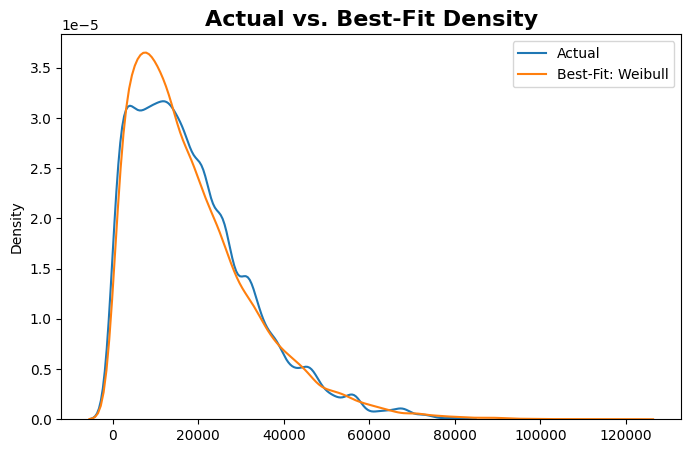

,nll,distribution
rank,,
1,330127.991610,Weibull
2,330452.687500,Gamma
3,331970.182679,Gumbel
4,334202.424368,LogNormal
5,335482.806681,Gaussian
6,339253.917981,Cauchy
7,351165.696079,StudentT
8,352757.812483,Laplace


In [1895]:
xgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

dist_nll = xgblss_dist_class.dist_select(target=y_train.values, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 5))
dist_nll

In [1896]:
import multiprocessing
import xgboost as xgb
from xgboostlss.distributions.Gamma import *
from xgboostlss.distributions.Weibull import  *
from xgboostlss.model import *

In [1897]:
n_cpu = multiprocessing.cpu_count()

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

In [1898]:
xgblss = XGBoostLSS(Weibull(stabilization="L2", response_fn="exp", loss_fn="crps"))

In [1899]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 0.3,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 8,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "reg_alpha":              ["float", {"low": 0,      "high": 5,     "log": False}],
    "reg_lambda":             ["float", {"low": 0.5,    "high": 5,     "log": True}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    "tree_method":    ["categorical", ["auto", "approx", "hist"]],
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=500,        # Number of boosting iterations.
                             nfold=6,                    # Number of cv-folds.
                             early_stopping_rounds=30,   # Number of early-stopping rounds
                             max_minutes=180,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=123                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2025-10-04 12:23:28,848] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-04 12:35:36,264] Trial 0 finished with value: 27802366.333333332 and parameters: {'eta': 0.013127347871638296, 'max_depth': 3, 'gamma': 1.5074442732613943e-06, 'subsample': 0.6410518152663129, 'reg_alpha': 3.5973448489278153, 'reg_lambda': 1.324574727142493, 'colsample_bytree': 0.9846113587076923, 'min_child_weight': 0.21231116392056626, 'booster': 'gbtree', 'tree_method': 'auto'}. Best is trial 0 with value: 27802366.333333332.
[I 2025-10-04 12:49:18,399] Trial 1 finished with value: 27505886.0 and parameters: {'eta': 0.01836724168457087, 'max_depth': 4, 'gamma': 3.741370722352163e-08, 'subsample': 0.5184354042643451, 'reg_alpha': 3.6899770286601785, 'reg_lambda': 0.7611350732746983, 'colsample_bytree': 0.34036140491799405, 'min_child_weight': 0.004864656779286272, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 1 with value: 27505886.0.
[I 2025-10-04 13:00:07,710] Trial 2 finished with value: 27565779.666666668 and parameters: {'eta': 0.01751758901521546, 'max_d

In [1900]:
#   Best trial:
#     Value: 42679722.666666664
#     Params: 
#     eta: 0.07560859083508131
#     max_depth: 3
#     gamma: 0.0004346342867875754
#     subsample: 0.988447828488564
#     reg_alpha: 2.597425596299047
#     reg_lambda: 2.0505224575876357
#     colsample_bytree: 0.29650293279225903
#     min_child_weight: 6.934185220081648
#     booster: gbtree
#     tree_method: auto
#     opt_rounds: 176


# Best trial:
#     Value: 27422091.666666668
#     Params: 
#     eta: 0.07560859083508131
#     max_depth: 3
#     gamma: 0.0004346342867875754
#     subsample: 0.988447828488564
#     reg_alpha: 2.597425596299047
#     reg_lambda: 2.0505224575876357
#     colsample_bytree: 0.29650293279225903
#     min_child_weight: 6.934185220081648
#     booster: gbtree
#     tree_method: auto
#     opt_rounds: 396
opt_params = {
    "eta": 0.07560859083508131,
    "max_depth": 3,
    "gamma": 0.0004346342867875754,
    "subsample": 0.988447828488564,
    "min_child_weight": 6.934185220081648,
    "reg_alpha": 2.597425596299047,
    "reg_lambda": 2.0505224575876357,
    "colsample_bytree": 0.29650293279225903,
    "booster": "gbtree",
    "tree_method": "auto",
    "opt_rounds": 396
}

In [1901]:
# opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

In [1902]:
from scipy.stats import gamma
from typing import Dict, Any, Tuple
import torch

def crps_gamma(y_true: np.ndarray, concentration: np.ndarray, rate: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    concentration = np.asarray(concentration)
    rate = np.asarray(rate)
    
    scale = 1.0 / rate
    from scipy.special import gamma as gamma_func, gammainc
    
    F_y = gamma.cdf(y_true, a=concentration, scale=scale)
    
    mean = concentration * scale
    
    crps_values = []
    for i in range(len(y_true)):
        samples = np.random.gamma(concentration[i], scale[i], 1000)
        term1 = np.mean(np.abs(samples - y_true[i]))
        term2 = 0.5 * np.mean(np.abs(samples[:, np.newaxis] - samples[np.newaxis, :]))
        
        crps_values.append(term1 - term2)
    
    return np.mean(crps_values)

def train_cv_with_oof(xgblss_model, 
                      opt_params: Dict[str, Any], 
                      X_train: np.ndarray, 
                      y_train: np.ndarray,
                      n_rounds: int,
                      n_folds: int = 5,
                      random_state: int = 123) -> Tuple[np.ndarray, float, list]:
    
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    oof_predictions = np.zeros((len(y_train), 2))
    fold_scores = []
    
    print(f"Starting {n_folds}-fold cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\n--- Fold {fold + 1}/{n_folds} ---")
        
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        dtrain_fold = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval_fold = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        xgblss_fold = XGBoostLSS(
            Gamma(stabilization="L2",     
                  response_fn="exp",      
                  loss_fn="crps"           
                 )
        )
        
        print(f"Training fold {fold + 1}...")
        xgblss_fold.train(
            params=opt_params,
            dtrain=dtrain_fold,
            num_boost_round=n_rounds,
            evals=[(dtrain_fold, 'train'), (dval_fold, 'validation')],
            early_stopping_rounds=30,
            verbose_eval=50
        )
        
        fold_pred_params = xgblss_fold.predict(
            dval_fold, 
            pred_type="parameters"
        )
        
        oof_predictions[val_idx, 0] = fold_pred_params.iloc[:, 0].values  # concentration
        oof_predictions[val_idx, 1] = fold_pred_params.iloc[:, 1].values  # rate
        
        fold_crps = crps_gamma(
            y_fold_val, 
            fold_pred_params.iloc[:, 0].values,  # concentration
            fold_pred_params.iloc[:, 1].values   # rate
        )
        
        fold_scores.append(fold_crps)
        print(f"Fold {fold + 1} CRPS: {fold_crps:.6f}")
    
    mean_crps = crps_gamma(
        y_train, 
        oof_predictions[:, 0],  
        oof_predictions[:, 1]  
    )
    
    print(f"\n=== Cross-Validation Results ===")
    print(f"Mean CRPS across folds: {np.mean(fold_scores):.6f}")
    print(f"Std CRPS across folds: {np.std(fold_scores):.6f}")
    print(f"Overall OOF CRPS: {mean_crps:.6f}")
    print(f"Individual fold scores: {fold_scores}")
    
    return oof_predictions, mean_crps, fold_scores

y_train = dtrain.get_label()

oof_preds, cv_score, fold_scores = train_cv_with_oof(
    xgblss_model=xgblss,
    opt_params=opt_params,
    X_train=X_train,
    y_train=y_train, 
    n_rounds=n_rounds,
    n_folds=6,
    random_state=123
)

print(f"\\nFinal CV CRPS Score: {cv_score:.6f}")

oof_df = pd.DataFrame(oof_preds, columns=['concentration', 'rate'])
print("\\nOOF Predictions Summary:")
print(oof_df.describe())
# k 123          42
# 3 7990.563731  8000.023088
# 4 7997.661658  8013.680341
# 5 7989.352705  8005.524561
# 6 7970.993408  7984.468779
# 7 8024.270602  7991.355755

Starting 6-fold cross-validation...

--- Fold 1/6 ---
Training fold 1...
[0]	train-crps:189867504.00000	validation-crps:38869392.00000
[50]	train-crps:146309760.00000	validation-crps:30077238.00000
[100]	train-crps:142301360.00000	validation-crps:29314974.00000
[150]	train-crps:138828992.00000	validation-crps:28785224.00000
[200]	train-crps:136912112.00000	validation-crps:28503376.00000
[250]	train-crps:135129152.00000	validation-crps:28111828.00000
[300]	train-crps:133892784.00000	validation-crps:28037018.00000
[350]	train-crps:132404152.00000	validation-crps:28115526.00000
[365]	train-crps:131934576.00000	validation-crps:27857952.00000
Fold 1 CRPS: 5300.289457

--- Fold 2/6 ---
Training fold 2...
[0]	train-crps:190443408.00000	validation-crps:38108248.00000
[50]	train-crps:146636064.00000	validation-crps:29309018.00000
[100]	train-crps:142433312.00000	validation-crps:28703624.00000
[150]	train-crps:139649328.00000	validation-crps:28267210.00000
[200]	train-crps:137308128.00000	valida

In [ ]:
xgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

In [ ]:
xgblss.save_model("xgblss_gamma_model.json")